# 第10章 数据分析实战—空气质量指数PM2.5分析

In [1]:
# coding: utf-8
from pyspark.sql.types import *
import pyspark.sql.functions as F

In [2]:
pwd = !pwd
data_path = "file://" + list(pwd)[0] + '/data/'
print(data_path)

file:///root/pyspark-book/data/


In [3]:
def get_health_level(value):
    """
    PM2.5对应健康级别设置
    :param value: PM2.5 
    :return: level
    """
    if 0 <= value <= 50:
        return "Very Good"
    elif 50 < value <= 100:
        return "Good"
    elif 100 < value <= 150:
        return "Unhealthy for Sensi"
    elif value <= 200:
        return "Unhealthy"
    elif 200 < value <= 300:
        return "Very Unhealthy"
    elif 300 < value <= 500:
        return "Hazardous"
    elif value > 500:
        return "Extreme danger"
    else:
        return None

In [4]:
# 1. 获取原始数据

In [5]:
df = spark.read.format("csv") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load(data_path + "Beijing_PM25.csv") \
    .select("Year", "Month", "Day", "Hour", "Value", "QC Name")

In [6]:
df.show(10)

+----+-----+---+----+-----+-------+
|Year|Month|Day|Hour|Value|QC Name|
+----+-----+---+----+-----+-------+
|2017|    1|  1|   0|  505|  Valid|
|2017|    1|  1|   1|  485|  Valid|
|2017|    1|  1|   2|  466|  Valid|
|2017|    1|  1|   3|  435|  Valid|
|2017|    1|  1|   4|  405|  Valid|
|2017|    1|  1|   5|  402|  Valid|
|2017|    1|  1|   6|  407|  Valid|
|2017|    1|  1|   7|  435|  Valid|
|2017|    1|  1|   8|  472|  Valid|
|2017|    1|  1|   9|  465|  Valid|
+----+-----+---+----+-----+-------+
only showing top 10 rows



In [7]:
df.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Day: integer (nullable = true)
 |-- Hour: integer (nullable = true)
 |-- Value: integer (nullable = true)
 |-- QC Name: string (nullable = true)



In [8]:
# 创建 health_level 列

In [9]:
health_level_udf = F.udf(get_health_level, StringType())

In [10]:
df = df.withColumn("healthy_level", health_level_udf("Value"))

In [11]:
df.show(10)

+----+-----+---+----+-----+-------+--------------+
|Year|Month|Day|Hour|Value|QC Name| healthy_level|
+----+-----+---+----+-----+-------+--------------+
|2017|    1|  1|   0|  505|  Valid|Extreme danger|
|2017|    1|  1|   1|  485|  Valid|     Hazardous|
|2017|    1|  1|   2|  466|  Valid|     Hazardous|
|2017|    1|  1|   3|  435|  Valid|     Hazardous|
|2017|    1|  1|   4|  405|  Valid|     Hazardous|
|2017|    1|  1|   5|  402|  Valid|     Hazardous|
|2017|    1|  1|   6|  407|  Valid|     Hazardous|
|2017|    1|  1|   7|  435|  Valid|     Hazardous|
|2017|    1|  1|   8|  472|  Valid|     Hazardous|
|2017|    1|  1|   9|  465|  Valid|     Hazardous|
+----+-----+---+----+-----+-------+--------------+
only showing top 10 rows



In [11]:
# 根据 healthy_level 进行分组

In [12]:
group_df = df.groupBy("healthy_level").count()

In [13]:
group_df.show(10)

+-------------------+-----+
|      healthy_level|count|
+-------------------+-----+
|          Unhealthy|  198|
|     Extreme danger|   27|
|               Good| 1021|
|          Very Good| 2438|
|Unhealthy for Sensi|  374|
|          Hazardous|  107|
|     Very Unhealthy|  179|
+-------------------+-----+



In [15]:
# 新建列days和percentage,并计算

In [16]:
sums = df.count()
print(sums)

4344


In [18]:
group_df.printSchema()

root
 |-- healthy_level: string (nullable = true)
 |-- count: long (nullable = false)



In [19]:
result_df = group_df\
        .withColumn("days", (F.col("count") / 24).cast(IntegerType())) \
        .withColumn("percentage", F.round(F.col("count") / sums, 3))

In [20]:
result_df.show(10)

+-------------------+-----+----+----------+
|      healthy_level|count|days|percentage|
+-------------------+-----+----+----------+
|          Unhealthy|  198|   8|     0.046|
|     Extreme danger|   27|   1|     0.006|
|               Good| 1021|  42|     0.235|
|          Very Good| 2438| 101|     0.561|
|Unhealthy for Sensi|  374|  15|     0.086|
|          Hazardous|  107|   4|     0.025|
|     Very Unhealthy|  179|   7|     0.041|
+-------------------+-----+----+----------+



In [20]:
result_df.repartition(1).write.csv(path=data_path+'result_PM2.5', mode="overwrite")

In [22]:
%cat ./data/result_PM2.5/part-00000-86dde251-a54c-4eda-aa35-81ae26418afc-c000.csv

Unhealthy,198,8,0.046
Extreme danger,27,1,0.006
Good,1021,42,0.235
Very Good,2438,101,0.561
Unhealthy for Sensi,374,15,0.086
Hazardous,107,4,0.025
Very Unhealthy,179,7,0.041


In [27]:
month_avg_df  =  df.groupBy("month").agg({"Value": "mean"})
month_avg_df.show()

+-----+------------------+
|month|        avg(Value)|
+-----+------------------+
|    1|108.73118279569893|
|    6|32.918055555555554|
|    3| 60.81720430107527|
|    5| 57.62096774193548|
|    4| 45.46944444444444|
|    2| 72.95982142857143|
+-----+------------------+



In [28]:
month_df  =  df.groupBy("month", "healthy_level").count()
month_df.show()

+-----+-------------------+-----+
|month|      healthy_level|count|
+-----+-------------------+-----+
|    5|          Unhealthy|    4|
|    1|     Very Unhealthy|   94|
|    5|               Good|  212|
|    3|     Very Unhealthy|   16|
|    2|               Good|  110|
|    2|          Unhealthy|   45|
|    6|          Very Good|  525|
|    1|          Very Good|  319|
|    4|Unhealthy for Sensi|   71|
|    6|Unhealthy for Sensi|    7|
|    4|               Good|  225|
|    6|          Unhealthy|    8|
|    4|          Unhealthy|   29|
|    4|          Very Good|  391|
|    6|               Good|  180|
|    2|     Very Unhealthy|   63|
|    1|          Hazardous|   71|
|    1|          Unhealthy|   54|
|    1|               Good|  109|
|    3|               Good|  185|
+-----+-------------------+-----+
only showing top 20 rows



In [29]:
pd_df = result_df.toPandas()

In [30]:
pd_df.head()

,healthy_level,count,days,percentage
0,Unhealthy,198,8,0.046
1,Extreme danger,27,1,0.006
2,Good,1021,42,0.235
3,Very Good,2438,101,0.561
4,Unhealthy for Sensi,374,15,0.086


In [31]:
# 使用饼图查看空气质量等级占比

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

/usr/local/src/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


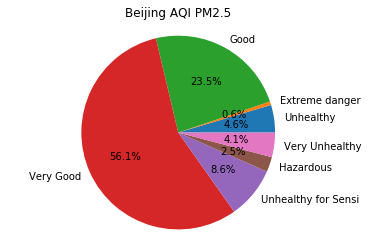

In [66]:
plt.title("Beijing AQI PM2.5")
labels = pd_df['healthy_level']
x = pd_df["percentage"]
plt.pie(x, labels=labels,autopct='%1.1f%%')
plt.axis("equal")
plt.show()